# Chapter 2: End-to-End Machine Learning Project
 
Welcome to the Machine Learning Housing Corporation! In this notebook, you will work through an end-to-end machine learning project, pretending to be a newly hired data scientist at a real estate company. The goal is to illustrate the main steps of a machine learning project, not to learn anything about the real estate business itself.

**Educational and Experimental Approach:**
- This notebook follows the sequential structure of the book, with explanations and code for each step.
- You are encouraged to experiment with the code, try different parameters, and observe the effects.
- Explanations in markdown cells will help you understand the reasoning behind each step, common pitfalls, and best practices.

**Project Steps:**
1. Look at the big picture and frame the problem
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data for machine learning algorithms
5. Select a model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor, and maintain your system

Let's get started!

## 1. Look at the Big Picture: Framing the Problem

Before jumping into code, let's clarify the business objective and frame the machine learning problem.

**Business Objective:**
- Predict the median housing price in any California district, given census data.
- The output will be used by a downstream system to help decide whether to invest in a given area.

**Key Questions:**
- What is the type of ML task? (Supervised, regression, batch learning)
- What performance metric should we use? (RMSE, MAE)

Let's define the RMSE and MAE formulas and discuss their differences.

## 2. Get the Data: Working with Real Data

When learning machine learning, it's best to experiment with real-world data. There are many open datasets available online. In this project, we'll use the California Housing Prices dataset from the StatLib repository, based on the 1990 California census.

**Why this dataset?**
- It contains real census data, including population, median income, and housing prices for each district.
- It's small enough to fit in memory, but large enough to be interesting.

Let's load the data. If you don't have the CSV file, you can use the following function to download and extract it automatically.

In [1]:
# Download and load the California housing data (if not already present)
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

# Load the data into a DataFrame
housing = load_housing_data()
housing.head()

C:\Users\User\AppData\Local\Temp\ipykernel_18932\3954615243.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Inspecting the Data Structure

Let's take a quick look at the data to understand its structure and contents. We'll use several pandas methods to get a feel for the dataset:
- `.info()` for a summary of columns, types, and missing values
- `.describe()` for statistics on numerical columns
- `.value_counts()` for categorical columns
- `.hist()` for visualizing distributions

This is a crucial step before any modeling, as it helps you spot issues and understand what you're working with.

In [2]:
# Get a concise summary of the DataFrame, including missing values
housing.info()  # Useful for understanding the data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:

# Check the distribution of the categorical attribute 'ocean_proximity'
housing['ocean_proximity'].value_counts()  # Shows the number of districts in each category

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [4]:

# Get summary statistics for numerical attributes
housing.describe()  # Includes count, mean, std, min, max, and percentiles

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


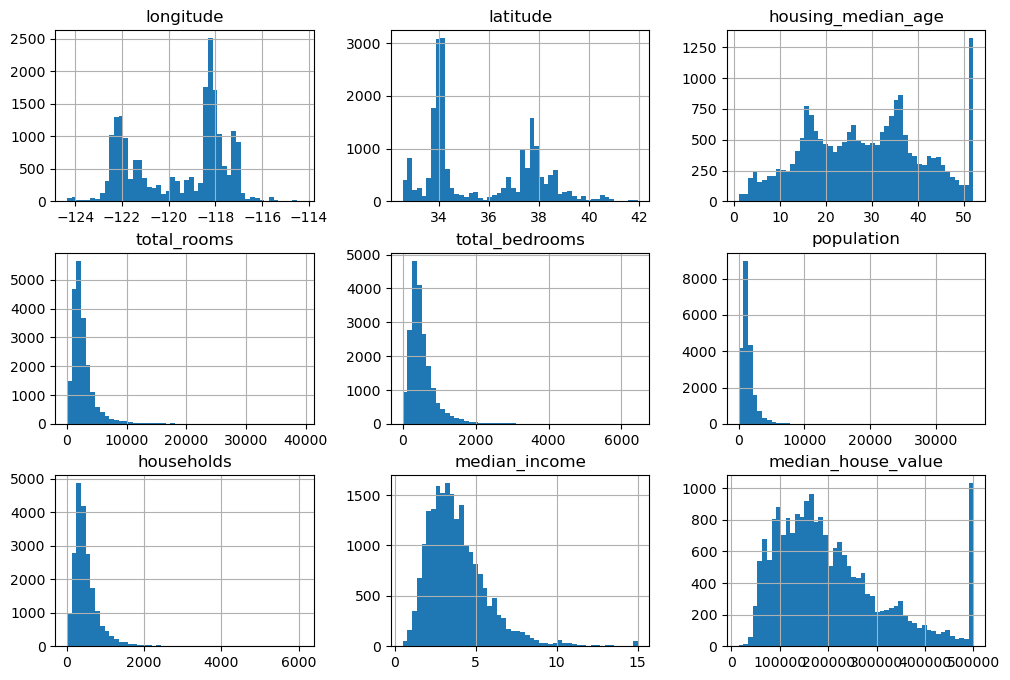

In [5]:

# Visualize the distribution of each numerical attribute
import matplotlib.pyplot as plt
%matplotlib inline
housing.hist(bins=50, figsize=(12, 8))
plt.show()

#### What did we learn from the data inspection?

- The dataset has 20,640 instances and 10 attributes.
- Most attributes are numerical, except for 'ocean_proximity', which is categorical.
- The 'total_bedrooms' attribute has missing values (about 207 missing out of 20,640).
- The 'ocean_proximity' column has a few distinct categories.
- Some attributes (like 'median_income' and 'median_house_value') are capped or have unusual distributions.
- Many attributes are right-skewed, which may affect some algorithms.

**These insights will guide our data cleaning, feature engineering, and modeling choices.**

## 3. Create a Test Set

Before exploring the data further, it's critical to set aside a test set. This helps prevent data snooping bias and ensures that our final evaluation is fair and unbiased.

### Why create a test set now?
- If you look at the test set during EDA or model selection, you risk overfitting to it.
- The test set should only be used for the final evaluation, after all modeling decisions are made.

Let's see several ways to split the data, including random splitting and stratified sampling based on income category.

In [6]:
# --- Random splitting (not stable across runs) ---
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(f"Random split: train set = {len(train_set)}, test set = {len(test_set)}")


Random split: train set = 16512, test set = 4128


In [7]:

# --- Stable splitting using row index as ID ---
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()  # adds an 'index' column
train_set_stable, test_set_stable = split_data_with_id_hash(housing_with_id, 0.2, "index")
print(f"Stable split: train set = {len(train_set_stable)}, test set = {len(test_set_stable)}")


Stable split: train set = 16512, test set = 4128


In [8]:

# --- Stratified sampling by income category ---
housing["income_cat"] = pd.cut(housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Check the proportions
print("Income category proportions in test set:")
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

# Remove the income_cat column so data is back to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Income category proportions in test set:
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


### Why stratified sampling?

- Stratified sampling ensures that the test set is representative of the overall dataset, especially for important attributes like income.
- Random splits can lead to sampling bias, especially with small or imbalanced datasets.
- After splitting, we drop the 'income_cat' column to revert the data to its original state.

**Now we are ready to explore the training set!**

## 4. Explore and Visualize the Data to Gain Insights

Now that we have a clean training set, let's explore it in depth. The goal is to understand the data, spot patterns, and discover relationships that will help us build better models.

**Key steps:**
- Visualize geographical data
- Look for correlations
- Experiment with attribute combinations

Let's start by making a copy of the training set for exploration.

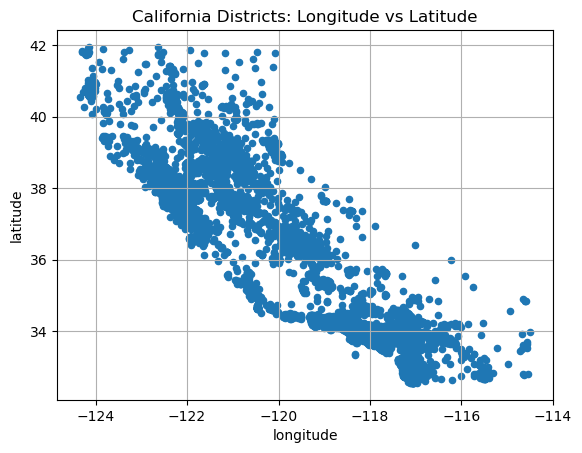

In [9]:
# Make a copy of the training set for exploration
explore_set = strat_train_set.copy()  # This way, we can experiment freely

# --- Geographical scatter plot ---
import matplotlib.pyplot as plt
explore_set.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.title("California Districts: Longitude vs Latitude")
plt.show()


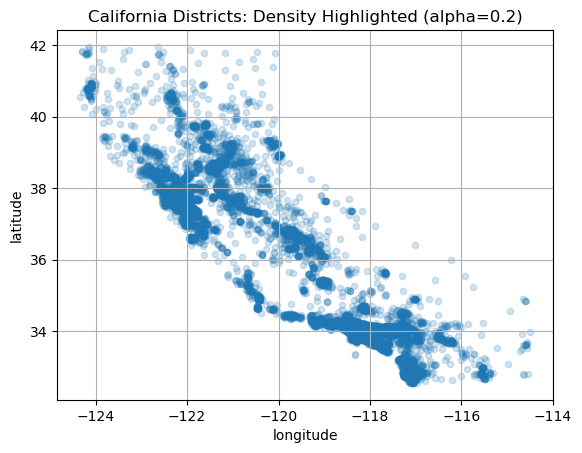

In [10]:

# --- Enhanced scatter plot with alpha for density ---
explore_set.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.title("California Districts: Density Highlighted (alpha=0.2)")
plt.show()


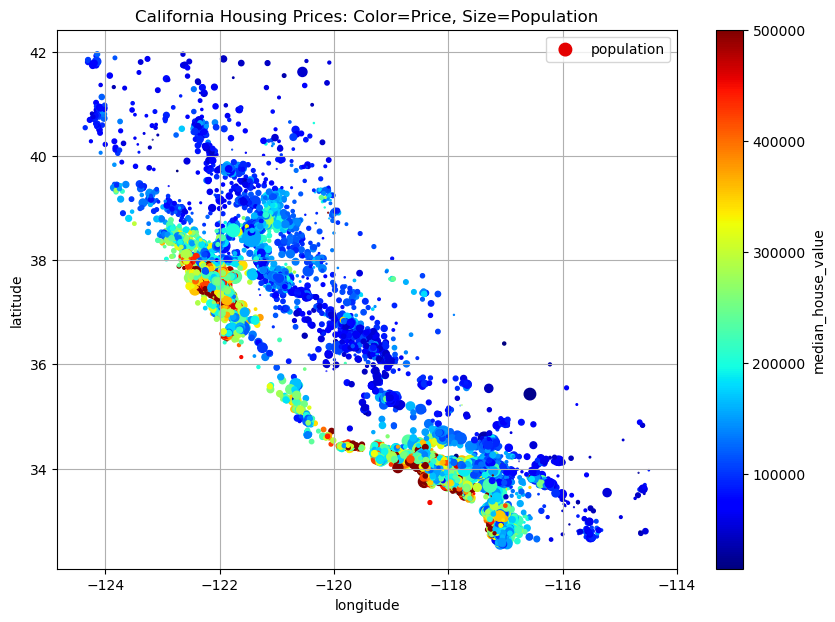

In [11]:

# --- Scatter plot with population and price color coding ---
explore_set.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                 s=explore_set["population"] / 100, label="population",
                 c="median_house_value", cmap="jet", colorbar=True,
                 legend=True, sharex=False, figsize=(10, 7))
plt.title("California Housing Prices: Color=Price, Size=Population")
plt.show()

### Insights from Geographical Visualizations

- The scatter plots show the geographical distribution of districts in California.
- Using alpha (transparency) helps highlight high-density areas (e.g., Bay Area, Los Angeles, San Diego).
- The color-coded plot reveals that housing prices are higher near the coast and in densely populated areas.
- These visualizations suggest that location and population density are important predictors of housing prices.

In [12]:
# --- Correlation analysis ---
corr_matrix = explore_set.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)  # See which features are most correlated with price

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

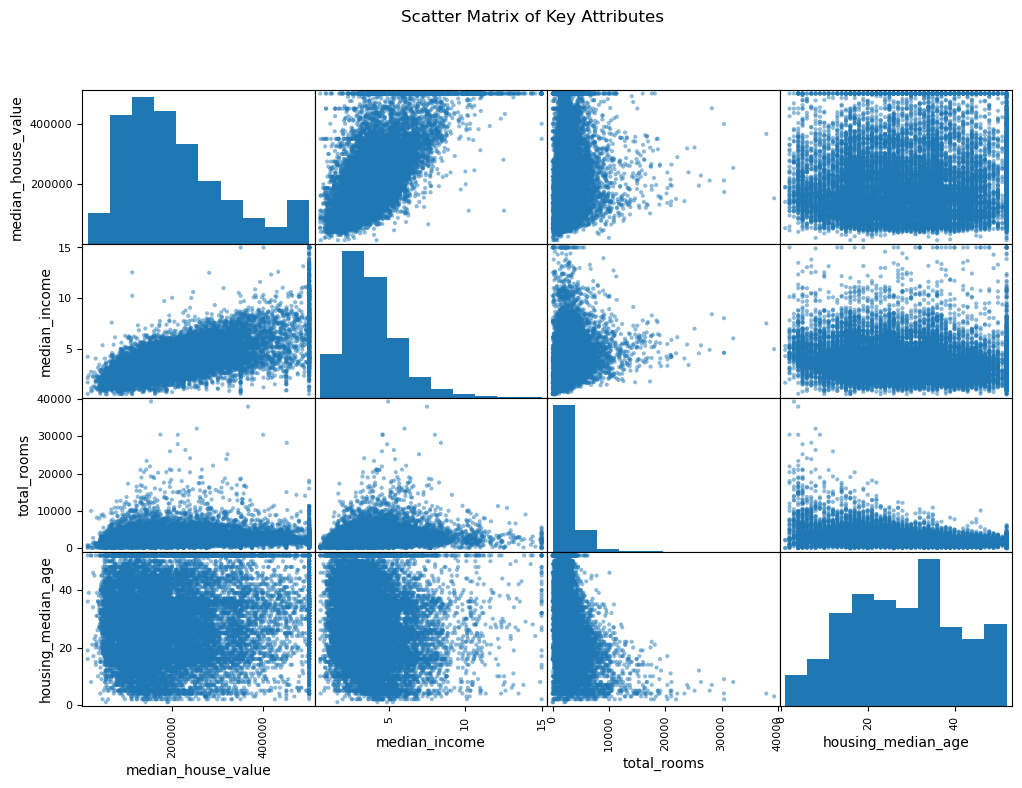

In [13]:

# --- Scatter matrix for selected attributes ---
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(explore_set[attributes], figsize=(12, 8))
plt.suptitle("Scatter Matrix of Key Attributes")
plt.show()

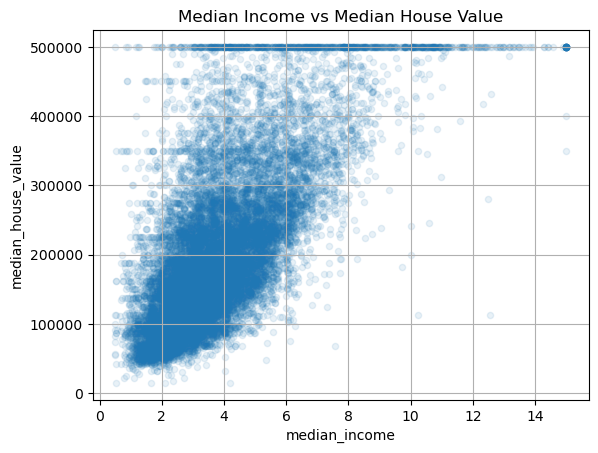

In [14]:

# --- Focused scatter plot: median_income vs median_house_value ---
explore_set.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.title("Median Income vs Median House Value")
plt.show()

### Correlation and Attribute Insights

- The correlation matrix shows that 'median_income' is the most strongly correlated feature with 'median_house_value'.
- The scatter matrix helps visualize relationships between key attributes.
- The focused scatter plot reveals a strong upward trend between median income and house value, but also shows capped values (horizontal lines), which may affect model performance.

**Next, let's experiment with new attribute combinations to see if we can find even better predictors!**

In [15]:
# --- Experiment with attribute combinations ---
explore_set["rooms_per_house"] = explore_set["total_rooms"] / explore_set["households"]
explore_set["bedrooms_ratio"] = explore_set["total_bedrooms"] / explore_set["total_rooms"]
explore_set["people_per_house"] = explore_set["population"] / explore_set["households"]

In [16]:

# Check correlations again
corr_matrix = explore_set.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### Attribute Engineering Insights

- Creating new features like 'rooms_per_house', 'bedrooms_ratio', and 'people_per_house' can reveal stronger relationships with the target.
- The 'bedrooms_ratio' attribute is more negatively correlated with house value than the raw bedroom or room counts.
- 'rooms_per_house' is also more informative than 'total_rooms'.

**Feature engineering is a powerful way to improve model performance!**

Next, we'll prepare the data for machine learning algorithms.

## 5. Prepare the Data for Machine Learning Algorithms

Now that we've explored the data and engineered some new features, it's time to prepare the data for machine learning algorithms.

**Key steps:**
- Handle missing values
- Encode categorical attributes
- Feature scaling
- Build transformation pipelines for reproducibility and experimentation

Let's start by separating the predictors and the labels.

In [17]:
# --- Separate predictors and labels ---
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [18]:

# --- Handle missing values with SimpleImputer ---
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number]) # Median can only be computed on numerical attributes. So we need to copy the data with only numerical attributes
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [19]:

# Show the learned medians
print("Imputer statistics (medians):", imputer.statistics_)
print("Pandas medians:", housing_num.median().values)

Imputer statistics (medians): [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
Pandas medians: [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [20]:

# Transform the data (replace missing values with medians)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [21]:
# --- Encode categorical attribute ---
from sklearn.preprocessing import OneHotEncoder
housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [22]:

# Show the learned categories
print("Categories:", cat_encoder.categories_)

Categories: [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [23]:

# Convert the sparse matrix to a dense array (for display)
housing_cat_1hot_array = housing_cat_1hot.toarray()
housing_cat_1hot_array[:5]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [24]:
# --- Feature scaling (Standardization) ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_num_scaled = scaler.fit_transform(housing_tr)

# Show the effect of scaling (mean ~0, std ~1)
print("Means after scaling:", housing_num_scaled.mean(axis=0))
print("Stds after scaling:", housing_num_scaled.std(axis=0))

Means after scaling: [-4.83721590e-15 -2.58083821e-15 -1.47384258e-17 -5.91688627e-17
  1.03922039e-16  4.76578294e-17  1.46308461e-17  7.61126734e-17]
Stds after scaling: [1. 1. 1. 1. 1. 1. 1. 1.]


### Feature Scaling

Machine learning algorithms do not perform well when the input numerical attributes have very different scales. For example, the `median_income` attribute ranges from 0 to 15, while the `total_rooms` attribute goes from 6 to 39,320. Feature scaling is essential to bring all attributes to the same scale.

There are two common ways to get all attributes to have the same scale:
- **Min-max scaling (normalization):** Values are shifted and rescaled so that they end up ranging from 0 to 1. This is done by subtracting the minimum value and dividing by the range (max - min).
- **Standardization:** Values are centered around 0 with a standard deviation of 1. Standardization is less affected by outliers than min-max scaling.

Here, we use `StandardScaler` from Scikit-Learn to standardize the features. This ensures that each attribute has a mean of 0 and a standard deviation of 1.

### Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations. Pipelines make the code cleaner and less error-prone, and they ensure that the same transformations are applied to both the training set and the test set.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# List of numerical and categorical attributes
num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

# Numerical pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print("Transformed numerical data (first 5 rows):\n", housing_num_tr[:5])

Transformed numerical data (first 5 rows):
 [[-1.42303652  1.0136059   1.86111875  0.31191221  1.36816703  0.13746004
   1.39481249 -0.93649149]
 [ 0.59639445 -0.702103    0.90762971 -0.30861991 -0.43592476 -0.69377062
  -0.37348471  1.17194198]
 [-1.2030985   1.27611874  0.35142777 -0.71224036 -0.76070869 -0.78876841
  -0.77572662 -0.75978881]
 [ 1.23121557 -0.88492444 -0.91989094  0.70226169  0.74230601  0.38317548
   0.73137454 -0.85028088]
 [ 0.71136206 -0.87554898  0.58980003  0.79012465  1.59575285  0.44437597
   1.75526303 -0.18036472]]


The code above creates a pipeline for the numerical attributes. The pipeline first replaces missing values with the median of each attribute using `SimpleImputer`, then scales the features using `StandardScaler`. This ensures that all numerical features are on the same scale and that missing values are handled properly. Pipelines help keep the code clean and make it easy to apply the same transformations to new data.

In [27]:
# Full pipeline: handle both numerical and categorical attributes
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
print("Transformed data shape:", housing_prepared.shape)

Transformed data shape: (16512, 13)


The code above creates a full preprocessing pipeline using Scikit-Learn's `ColumnTransformer`. This pipeline applies the numerical pipeline to all numerical attributes and the `OneHotEncoder` to the categorical attribute. The result is a NumPy array containing all the processed features, ready to be fed into a machine learning algorithm. The shape of the transformed data shows the total number of features after all transformations, including the one-hot encoded categorical features.

## Select and Train a Model

Now that the data is clean and ready for Machine Learning algorithms, the next step is to select and train a model. We will start by training a simple Linear Regression model and evaluate its performance.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:

# Make predictions on the training set
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Linear Regression RMSE on training set:", lin_rmse)

Linear Regression RMSE on training set: 68232.83515124217


The code above trains a Linear Regression model using the prepared data. After fitting the model, it makes predictions on the training set and computes the Root Mean Squared Error (RMSE) to evaluate the model's performance. The RMSE gives an idea of how much error the model makes on average when predicting housing values. A lower RMSE indicates a better fit, but keep in mind that evaluating on the training set can be misleading if the model overfits.

In [30]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [31]:

# Make predictions on the training set
housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)

print("Decision Tree RMSE on training set:", tree_rmse)

Decision Tree RMSE on training set: 0.0


The code above trains a Decision Tree Regressor on the training data. After fitting the model, it makes predictions on the training set and computes the RMSE. Notice that the RMSE is much lower than with Linear Regression, which suggests that the model may be overfitting the training data. This is a common issue with powerful models like decision trees, which can fit the training data very closely but may not generalize well to new data.

In [32]:
from sklearn.model_selection import cross_val_score

# Evaluate Decision Tree with cross-validation
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [33]:

print("Decision Tree cross-validation RMSE scores:", tree_rmse_scores)
print("Mean:", tree_rmse_scores.mean())
print("Standard deviation:", tree_rmse_scores.std())

Decision Tree cross-validation RMSE scores: [69056.8325947  67221.26914592 67397.26251734 70028.77835992
 68458.77550024 71464.31138671 71044.35429084 68688.64095706
 67300.66681156 66647.53141818]
Mean: 68730.84229824627
Standard deviation: 1585.362175240545


To get a better estimate of the model's performance, we use cross-validation. The `cross_val_score` function splits the training set into 10 folds, trains and evaluates the model 10 times, and returns the scores. The mean and standard deviation of the RMSE scores provide a more reliable estimate of the model's generalization performance. As you can see, the Decision Tree model performs much worse on the validation folds than on the training set, confirming that it is overfitting.

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest Regressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:

# Evaluate with cross-validation
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest cross-validation RMSE scores:", forest_rmse_scores)
print("Mean:", forest_rmse_scores.mean())
print("Standard deviation:", forest_rmse_scores.std())

Random Forest cross-validation RMSE scores: [48484.96959165 50000.16612239 47505.35064619 49316.09714579
 48428.76921481 49128.82161789 48456.75463566 49460.26983712
 48874.68869078 49358.24455204]
Mean: 48901.41320543065
Standard deviation: 670.5367015311969


The code above trains a Random Forest Regressor, which is an ensemble of Decision Trees. It then evaluates the model using cross-validation. Random Forests generally perform better than individual Decision Trees by reducing overfitting and improving generalization. The mean and standard deviation of the RMSE scores provide an estimate of the model's performance and its stability across different folds.

In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = [
    {'n_estimators': [30, 50, 100], 'max_features': [6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [30, 50], 'max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)  # Use all CPU cores
grid_search.fit(housing_prepared, housing_labels)

print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best parameters: {'bootstrap': False, 'max_features': 6, 'n_estimators': 50}
Best estimator: RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=50,
                      random_state=42)
49323.243711770556 {'max_features': 6, 'n_estimators': 30}
48888.549905631895 {'max_features': 6, 'n_estimators': 50}
48758.597184344566 {'max_features': 6, 'n_estimators': 100}
49405.12590663484 {'max_features': 8, 'n_estimators': 30}
49026.604248192336 {'max_features': 8, 'n_estimators': 50}
48848.00687346251 {'max_features': 8, 'n_estimators': 100}
49511.25990324674 {'max_features': 10, 'n_estimators': 30}
49220.73147513812 {'max_features': 10, 'n_estimators': 50}
48994.799300742896 {'max_features': 10, 'n_estimators': 100}
48907.60797554902 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
48502.64588548183 {'bootstrap': False, 'max_features': 6, 'n_estimators': 50}
49790.368375365564 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
49309.78192069647 {'bootstra

The code above uses `GridSearchCV` to search for the best hyperparameters for the Random Forest model. It tries different combinations of `n_estimators` and `max_features`, both with and without bootstrapping, using 5-fold cross-validation. The best parameters and estimator are displayed, along with the RMSE for each combination. Grid search is a powerful way to systematically explore hyperparameter spaces and find the best model for your data.

In [38]:
# Display feature importances from the best Random Forest model
feature_importances = grid_search.best_estimator_.feature_importances_

# Get attribute names after one-hot encoding
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted_feat = sorted(zip(feature_importances, attributes), reverse=True)
print("Feature importances:")
for score, name in sorted_feat:
    print(f"{name}: {score}")

Feature importances:
median_income: 0.4114813245971841
population_per_household: 0.1379294659844505
longitude: 0.12866942087358646
latitude: 0.11391408283508926
housing_median_age: 0.045799176541035554
population: 0.04182084560585331
total_rooms: 0.034394060613949735
total_bedrooms: 0.028656817222183665
households: 0.026597632227618576
rooms_per_household: 0.017441137012587392
INLAND: 0.00836397595611998
<1H OCEAN: 0.004680069874536937
bedrooms_per_room: 0.0002519906558045239


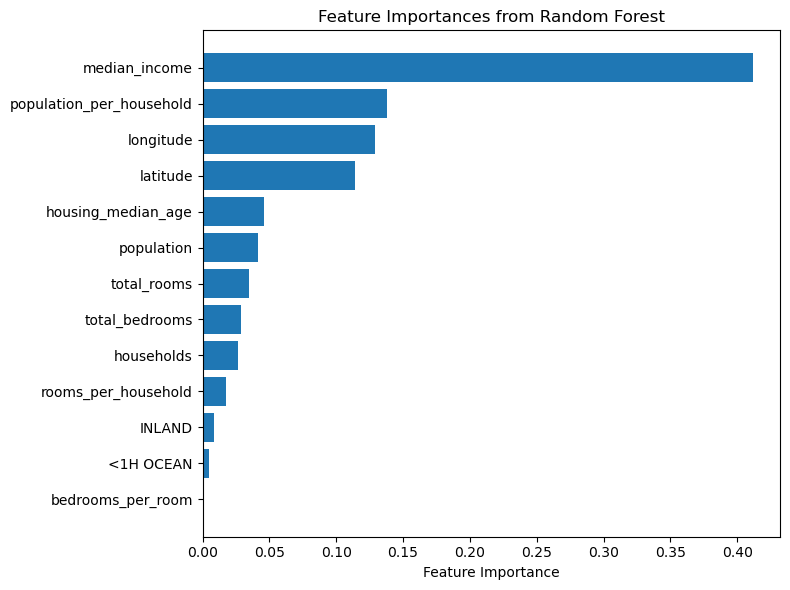

In [39]:
import matplotlib.pyplot as plt

# Visualize feature importances
feat_scores = sorted(zip(feature_importances, attributes), reverse=True)
importances, names = zip(*feat_scores)
plt.figure(figsize=(8, 6))
plt.barh(names, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The code above displays the feature importances computed by the best Random Forest model. Feature importances indicate how much each attribute contributes to the model's predictions. This information can help you understand the model and identify which features are most relevant for predicting house values. You can use this insight to select the most important features or to engineer new ones.

In [40]:
# Evaluate the final model on the test set
final_model = grid_search.best_estimator_

# Prepare the test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final model RMSE on test set:", final_rmse)

Final model RMSE on test set: 49357.72519567888


The code above evaluates the final model on the test set. The test set is transformed using the same preprocessing pipeline, and predictions are made using the best model found by grid search. The RMSE on the test set provides an unbiased estimate of the model's performance on new, unseen data. This is the final step in the end-to-end machine learning project, and it gives you a realistic idea of how well your model will perform in production.